# Notebook for evaluating and training baseline models

In [1]:
import sys
from pathlib import Path

# Add the parent directory of this script to sys.path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))

# Now you can import modules from the parent directory
import torch
from helpers.simulation import *
from helpers.models import *
from helpers.training import train_single_mode, train_multi_state
from helpers.eval import *
from settings import *
import matplotlib.pyplot as plt
import os

## LSTM Evaluation

### Single-state

In [ ]:
# Define model parameters
model_props= {
    "lr": 1e-4,
    "embed_dim": 64,
    "num_heads": 4,
    "hidden_dim": 128,
    "num_layers": 4,
    "dropout": 0.01,
    "batch_size": 16,
    "loss_fn": mse_loss,
    "weight_decay": 0.01,
    "model": LSTM
}

if model_props['loss_fn'] is mse_loss_coeff:
    output_size = 2
else: 
    output_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = LSTM(model_props['embed_dim'], model_props['hidden_dim'], model_props['num_layers'], output_size, bidirectional=False, dropout=model_props['dropout'], pointwise=False)

print(f"Total params of {model.__class__.__name__}: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Load pretrained model
model_path = '../results/lstm_200000_20_64_0.0001_0.01.pt'
checkpoint = torch.load(model_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

In [ ]:
import numpy as np

# Image parameters
N = 5000 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame

image_props = SINGLE_STATE_PROPS

#np.random.seed(1)

losses = []
for i in range(1):
    all_videos, og_labels = create_training_set(N, T, image_props)

    loss = single_state_eval(all_videos, None, og_labels, None, model, model_props['loss_fn'], image_props['D_max_norm'], device)

    losses.append(loss)

losses = np.array(losses)

print(f"Average loss: {losses.mean()}")
print(f"Std of loss: {losses.std()}")

### Multi-state Binding

In [2]:
# Define model parameters
model_props= {
    "lr": 1e-4,
    "embed_dim": 64,
    "num_heads": 4,
    "hidden_dim": 128,
    "num_layers": 4,
    "dropout": 0.01,
    "batch_size": 16,
    "loss_fn": mse_loss,
    "weight_decay": 0.01,
    "model": LSTM
}

if model_props['loss_fn'] is mse_loss_coeff:
    output_size = 2
else: 
    output_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = LSTM(model_props['embed_dim'], model_props['hidden_dim'], model_props['num_layers'], output_size, bidirectional=False, dropout=model_props['dropout'], pointwise=True)

print(f"Total params of {model.__class__.__name__}: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Load pretrained model
model_path = '../results/lstm_multi_state_binding_250000_20_64_0.0001_0.05.pt'
checkpoint = torch.load(model_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

Using device: cuda
Total params of LSTM: 809252


LSTM(
  (image_encoder): DeepResNetEmbedding(
    (initial_conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (res_block1): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (res_block2): ResidualBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), strid

In [3]:
import numpy as np

# Image parameters
N = 5000 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame

image_props = BINDING_IMAGE_PROPS

losses = []
for i in range(1):
    all_videos, _, og_labels = create_multi_state_dataset_w_features(N, T, image_props, binding=True)

    loss = multi_state_eval(all_videos, None, og_labels, None, model, model_props['loss_fn'], image_props['D_max_norm'], device)

    losses.append(loss)

losses = np.array(losses)

print(f"Average loss: {losses.mean()}")
print(f"Std of loss: {losses.std()}")

Creating a binding dataset
Average loss across validation set: 0.47921870373616554
Average MAE of diffusion coefficients and angle simularity across validation set: [0.38078368 0.34038362 0.92257446]
--------------------------------------------------
Average loss: 0.47921870373616554
Std of loss: 0.0


### Multi-state Isotropic

In [ ]:
# Define model parameters
model_props= {
    "lr": 1e-4,
    "embed_dim": 64,
    "num_heads": 4,
    "hidden_dim": 128,
    "num_layers": 4,
    "dropout": 0.01,
    "batch_size": 16,
    "loss_fn": mse_loss_coeff,
    "weight_decay": 0.01,
    "model": LSTM
}

if model_props['loss_fn'] is mse_loss_coeff:
    output_size = 2
else: 
    output_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = LSTM(model_props['embed_dim'], model_props['hidden_dim'], model_props['num_layers'], output_size, bidirectional=False, dropout=model_props['dropout'], pointwise=True)

print(f"Total params of {model.__class__.__name__}: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Load pretrained model
model_path = '../results/lstm_multi_state_iso_200000_15_64_0.0001_0.01.pt'
checkpoint = torch.load(model_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

In [ ]:
import numpy as np

# Image parameters
N = 5000 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame

image_props = ISOTROPIC_PROPS

losses = []
for i in range(1):
    all_videos, _, og_labels = create_multi_state_dataset_w_features(N, T, image_props, binding=False)

    loss = multi_state_eval_isotropic(all_videos, None, og_labels, None, model, model_props['loss_fn'], image_props['D_max_norm'], device)

    losses.append(loss)

losses = np.array(losses)

print(f"Average loss: {losses.mean()}")
print(f"Std of loss: {losses.std()}")

## Pix2d Evaluation

### Single-state

In [ ]:
# Define model parameters
model_props= {
    "lr": 1e-4,
    "embed_dim": 64,
    "num_heads": 4,
    "hidden_dim": 128,
    "num_layers": 4,
    "dropout": 0.01,
    "batch_size": 16,
    "loss_fn": mse_loss,
    "weight_decay": 0.01,
    "model": Pix2D
}

if model_props['loss_fn'] is mse_loss_coeff:
    output_size = 2
else: 
    output_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = Pix2D(output_dim=output_size, pointwise=False)

print(f"Total params of {model.__class__.__name__}: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Load pretrained model
model_path = '../results/pix2d_300000_30_64_0.0001_0.01.pt'
checkpoint = torch.load(model_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

In [ ]:
import numpy as np

# Image parameters
N = 5000 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame

image_props = SINGLE_STATE_PROPS

#np.random.seed(1)

losses = []
for i in range(1):
    all_videos, og_labels = create_training_set(N, T, image_props)

    loss = single_state_eval(all_videos, None, og_labels, None, model, model_props['loss_fn'], image_props['D_max_norm'], device)

    losses.append(loss)

losses = np.array(losses)

print(f"Average loss: {losses.mean()}")
print(f"Std of loss: {losses.std()}")

### Sliding Window for Multi-state Binding

In [ ]:
import numpy as np

# Image parameters
N = 5000 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame

image_props = BINDING_IMAGE_PROPS

losses = []
for i in range(1):
    all_videos, _, og_labels = create_multi_state_dataset_w_features(N, T, image_props, binding=True)

    loss = single_state_sliding_window_eval(all_videos, None, og_labels, None, model, model_props['loss_fn'], image_props['D_max_norm'], device, window_size=10)

    losses.append(loss)

losses = np.array(losses)

print(f"Average loss: {losses.mean()}")
print(f"Std of loss: {losses.std()}")

### Sliding Window for Multi-state Isotropic

In [ ]:
import numpy as np

# Image parameters
N = 5000 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame

image_props = ISOTROPIC_PROPS

losses = []
for i in range(1):
    all_videos, _, og_labels = create_multi_state_dataset_w_features(N, T, image_props, binding=False)

    # Loss isn't correct due to output size of model forcing prediction of an angle
    loss = single_state_sliding_window_eval_iso(all_videos, None, og_labels, None, model, model_props['loss_fn'], image_props['D_max_norm'], device, window_size=10)

    losses.append(loss)

losses = np.array(losses)

print(f"Average loss: {losses.mean()}")
print(f"Std of loss: {losses.std()}")

### Multi-state Binding

In [ ]:
# Define model parameters
model_props= {
    "lr": 1e-4,
    "embed_dim": 64,
    "num_heads": 4,
    "hidden_dim": 128,
    "num_layers": 4,
    "dropout": 0.01,
    "batch_size": 16,
    "loss_fn": mse_loss,
    "weight_decay": 0.01,
    "model": Pix2D
}

if model_props['loss_fn'] is mse_loss_coeff:
    output_size = 2
else: 
    output_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = Pix2D(output_dim=output_size, pointwise=True)

print(f"Total params of {model.__class__.__name__}: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Load pretrained model
model_path = '../results/pix2d_multi_state_binding_100000_10_64_0.0001_0.01.pt'
checkpoint = torch.load(model_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

In [ ]:
import numpy as np

# Image parameters
N = 5000 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame

image_props = BINDING_IMAGE_PROPS

losses = []
for i in range(1):
    all_videos, _, og_labels = create_multi_state_dataset_w_features(N, T, image_props, binding=True)

    loss = multi_state_eval(all_videos, None, og_labels, None, model, model_props['loss_fn'], image_props['D_max_norm'], device)

    losses.append(loss)

losses = np.array(losses)

print(f"Average loss: {losses.mean()}")
print(f"Std of loss: {losses.std()}")

### Multi-state Isotropic

In [ ]:
# Define model parameters
model_props= {
    "lr": 1e-4,
    "embed_dim": 64,
    "num_heads": 4,
    "hidden_dim": 128,
    "num_layers": 4,
    "dropout": 0.01,
    "batch_size": 16,
    "loss_fn": mse_loss_coeff,
    "weight_decay": 0.01,
    "model": Pix2D
}

if model_props['loss_fn'] is mse_loss_coeff:
    output_size = 2
else: 
    output_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = Pix2D(output_dim=output_size, pointwise=True)

print(f"Total params of {model.__class__.__name__}: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Load pretrained model
model_path = '../results/pix2d_multi_state_iso_100000_20_64_0.0001_0.05.pt'
checkpoint = torch.load(model_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

In [ ]:
import numpy as np

# Image parameters
N = 5000 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame

image_props = ISOTROPIC_PROPS

losses = []
for i in range(1):
    all_videos, _, og_labels = create_multi_state_dataset_w_features(N, T, image_props, binding=False)

    loss = multi_state_eval_isotropic(all_videos, None, og_labels, None, model, model_props['loss_fn'], image_props['D_max_norm'], device)

    losses.append(loss)

losses = np.array(losses)

print(f"Average loss: {losses.mean()}")
print(f"Std of loss: {losses.std()}")

## Changepoint Predictions

In [4]:
"""
Run one of above evaluations to create dataset you want (e.g. binding or isotropic)
"""

# Normalize labels for better optimization
D_max_normalization = image_props['D_max_norm']
all_labels = og_labels / np.array([D_max_normalization, D_max_normalization, 1])

# Convert to tensors
all_videos = torch.Tensor(all_videos)
all_labels = torch.Tensor(all_labels)

# Create dataset and dataloader objects
dataset = VideoDataset(all_videos, all_labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

batch_loss = []
errors = []

plot_preds = []
plot_labels = []

with torch.no_grad():    
    for videos, displacements, labels in dataloader:
        videos = videos.to(device)
        labels = labels.to(device)
        
        val_predictions = model(videos)
        
        plot_preds.extend([p.cpu() for p in val_predictions])
        plot_labels.extend([l.cpu() for l in labels])

In [5]:
from ipywidgets import interact, IntSlider

@interact(i=IntSlider(value=0, min=0, max=len(plot_preds), step=1))
def plot_point_based(i):
    # Plot predictions and labels across frames
    fig, (ax1,ax2) = plt.subplots(2,1)

    pred_D1 = plot_preds[i][:,0] * D_max_normalization
    pred_D2 = plot_preds[i][:,1] * D_max_normalization
    label_D1 = plot_labels[i][:,0] * D_max_normalization
    label_D2 = plot_labels[i][:,1] * D_max_normalization

    ax1.plot(pred_D1, label='Prediction')
    ax1.plot(label_D1, label='Label')
    ax2.plot(pred_D2)
    ax2.plot(label_D2)
    fig.suptitle('Point-based Prediction')
    ax1.set_ylabel(r'$D_{1}$ ($\frac{\mu m^2}{s}$)')
    ax2.set_ylabel(r'$D_{2}$ ($\frac{\mu m^2}{s}$)')
    fig.supxlabel('Frame')

    fig.legend()
    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=5000), Output()), _dom_classes=('widget-interact…

In [6]:
p = np.array(plot_preds)
l = np.array(plot_labels)

changepoints_pred = get_changepoints(p[..., :2])
changepoints_labels = get_changepoints(l[...,:-1])

errors = np.abs(changepoints_pred - changepoints_labels)

vals, cnts = np.unique(errors, return_counts=True)

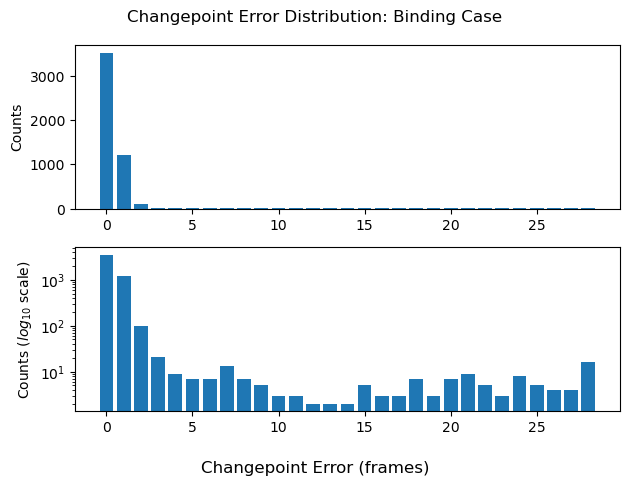

In [7]:
fig, (ax1, ax2) = plt.subplots(2,1)

ax1.bar(vals, cnts)
ax1.set_ylabel('Counts')

ax2.bar(vals, cnts)
ax2.set_yscale('log')
ax2.set_ylabel(r'Counts ($log_{10}$ scale)')

fig.supxlabel('Changepoint Error (frames)')
fig.suptitle('Changepoint Error Distribution: Binding Case')
fig.tight_layout()
plt.show()

## Baseline Training

In [ ]:
# Define model parameters
model_props= {
    "lr": 1e-4,
    "embed_dim": 64,
    "num_heads": 4,
    "hidden_dim": 128,
    "num_layers": 4,
    "dropout": 0.01,
    "batch_size": 16,
    "loss_fn": mse_loss,
    "weight_decay": 0.01,
    "model": LSTM
}

if model_props['loss_fn'] is mse_loss_coeff:
    output_size = 2
else: 
    output_size = 4

# Image parameters
N = 200000 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame
# values from Real data
background_mean,background_sigma = 1420, 290
part_mean, part_std = 6000 - background_mean,500

image_props = SINGLE_STATE_PROPS

# Number of cycles of generating training data and training
cycles = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

save_results = False

In [ ]:
# Keep track of loss across training for plotting
losses = []
vlosses = []
val_name = 'validation_data_11.npz'
#val_name = 'multi_state_iso_11.npz'

# Train model
if model_props['model'] is LSTM:
    model = LSTM(model_props['embed_dim'], model_props['hidden_dim'], 
            model_props['num_layers'], output_size, bidirectional=False, dropout=model_props['dropout'], pointwise=False)
else:
    model = Pix2D(output_dim=output_size, pointwise=False)

print(f"Total params of {model.__class__.__name__}: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
train_single_mode(model, N, T, model_props, image_props, device, cycles, losses, vlosses, val_path='../data/'+val_name)
#train_multi_state(model, N, T, model_props, image_props, device, cycles, losses, vlosses, val_path='../data/'+val_name, binding=False, is_baseline=True)

# Evaluation
model.eval()
for file in [f for f in os.listdir('../data') if f.startswith(val_name)]:
    # Get validation data
    data = np.load('../data/' + file)
    videos = torch.Tensor(data['vids'])
    #displacements = torch.Tensor(data['disp'])
    labels = torch.Tensor(data['labels'])
    
    D_max_normalization = image_props['D_max_norm']
    labels = labels / torch.Tensor([D_max_normalization, D_max_normalization, 1])

    # Create dataset and dataloader
    dataset = VideoDataset(videos, labels)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    with torch.no_grad():
        loss = []
        errors = []
        for videos, _, labels in dataloader:
            videos = videos.to(device)
            labels = labels.to(device)
            
            val_predictions = model(videos)

            val_loss = model_props['loss_fn'](val_predictions, labels)
            loss.append(val_loss.item()) # batch loss

            angle_pred = 0.5 * torch.atan2(val_predictions[...,2], val_predictions[...,3])
            if model_props['loss_fn'] is mse_loss or mse_loss_coeff:
                mae = (val_predictions[...,:2] - labels[...,:-1]).abs().mean(axis=((0,1) if labels.dim()==3 else 0))
            else:
                mae = (torch.exp(val_predictions[...,:2]) - labels[...,:-1]).abs().mean(axis=((0,1) if labels.dim()==3 else 0))

            angle_sim = torch.abs(torch.cos(angle_pred - labels[...,-1])).mean().unsqueeze(-1)
            errors.append(torch.cat([
                    mae.cpu() * D_max_normalization,
                    angle_sim.cpu()
                ], axis=0))
            #errors.append(
            #    mae.cpu() * D_max_normalization
            #)

        # Compute average across all labels
        avg_loss = np.mean(loss)
        avg_error = np.mean(errors, axis=0)
        print(file[:-4])
        print(f"Average loss across validation set: {avg_loss}")
        print(f"Average MAE of diffusion coefficients and angle simularity across validation set: {avg_error}")
        print(50*'-')

if save_results:
    path = f'../results/pix2d_multi_state_iso_{N}_{cycles}_{model_props["embed_dim"]}_{model_props["lr"]}_{model_props["dropout"]}.pt'
    checkpoint = {
        "model_state_dict": model.state_dict()
    }
    torch.save(checkpoint, path)
    print(f"Saved model to path: {path}")
    
# Plot loss over time during training
fig, ax = plt.subplots()
ax.plot(losses, 'r', label='Training')
ax.plot(vlosses, 'b*', label='Validation')
ax.set_title('Loss across training cycles')
ax.set_ylabel('Loss')
ax.set_xlabel('Cycle')
ax.legend()
fig.tight_layout()
plt.show()

## MSD Baseline

In [ ]:
import numpy as np
from helpers.helpersMSD import *

np.random.seed(1)

# Image parameters
N = 5000 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame
# values from Real data
background_mean,background_sigma = 1420, 290
part_mean, part_std = 6000 - background_mean,500

image_props = SINGLE_STATE_PROPS

# Must alter below function to return centroids
videos, displacement, labels, centroids, pos = create_training_set_w_features(N, T, image_props)

### Using Exact Position Data

In [ ]:
# Compute covariance matrices for each particle and time lags
C, taus = compute_covariance_matrix(pos)

# Estimate diffusion tensor from covariance matrix
D = estimate_diffusion_tensor(C, taus)

# Decompose tensor to get diffusion coeff and angle
vals, angles = diffusion_tensor_decomposition(D)

plotMSD(C, taus)

In [ ]:
mae = np.stack([
    np.abs(vals[:,0] - labels[:,0]), 
    np.abs(vals[:,1] - labels[:,1]),
    ], axis=1).mean(axis=0)

angle_sim = np.array([np.abs(np.cos(angles - labels[:,-1])).mean()])
errors = np.concatenate((mae, angle_sim), axis=0)

print(f"Average MAE of diffusion coefficients and angle simularity across validation set: {errors}")

### Use centroid positioning

In [ ]:
# Undo conversions to get back to units of simulation
centroids = centroids * image_props['resolution'] * 1e6

# Compute covariance matrices for each particle and time lags
C, taus = compute_covariance_matrix(centroids)

# Estimate diffusion tensor from covariance matrix
D = estimate_diffusion_tensor(C, taus)

# Decompose tensor to get diffusion coeff and angle
vals, angles = diffusion_tensor_decomposition(D)

plotMSD(C, taus)

In [ ]:
mae = np.stack([
    np.abs(vals[:,0] - labels[:,0]), 
    np.abs(vals[:,1] - labels[:,1]),
    ], axis=1).mean(axis=0)

angle_sim = np.array([np.abs(np.cos(angles - labels[:,-1])).mean()])
errors = np.concatenate((mae, angle_sim), axis=0)

print(f"Average MAE of diffusion coefficients and angle simularity across validation set: {errors}")

In [ ]:
# Decompose to each parameter
p1_pred = vals[..., 0]
p2_pred = vals[..., 1]
sin_2theta_pred = np.sin(2 * angles)
cos_2theta_pred = np.cos(2 * angles)

# Normalize predicted sin/cos
norm = np.sqrt(sin_2theta_pred**2 + cos_2theta_pred**2 + 1e-8)
sin_2theta_pred = sin_2theta_pred / norm
cos_2theta_pred = cos_2theta_pred / norm

# Compute true values
theta = labels[..., -1]
sin_2theta_true = np.sin(2 * theta)
cos_2theta_true = np.cos(2 * theta)

# MSE on diffusion and angular parts
mse_diffusion = (p1_pred - labels[..., 0])**2 + (p2_pred - labels[..., 1])**2
mse_angle = (sin_2theta_pred - sin_2theta_true)**2 + (cos_2theta_pred - cos_2theta_true)**2

(mse_diffusion + mse_angle).mean()